In [1]:
from timeit import default_timer as timer
from functools import partial
import yaml
import sys

from estimagic import maximize
from scipy.optimize import root_scalar
from scipy.stats import chi2
import numdifftools as nd
import pandas as pd
import respy as rp
import numpy as np

sys.path.insert(0, "python")
from auxiliary import plot_bootstrap_distribution  # noqa: E402
from auxiliary import plot_computational_budget  # noqa: E402
from auxiliary import plot_smoothing_parameter  # noqa: E402
from auxiliary import plot_score_distribution  # noqa: E402
from auxiliary import plot_score_function  # noqa: E402
from auxiliary import plot_likelihood  # noqa: E402

# Maximum likelihood estimation

## Introduction

EKW models are calibrated to data on observed individual decisions and experiences under the hypothesis that the individual's behavior is generated from the solution to the model. The goal is to back out information on reward functions, preference parameters, and transition probabilities. This requires the full parameterization $\theta$ of the model.

Economists have access to information for $i = 1, ..., N$ individuals in each time period $t$. For every observation $(i, t)$ in the data, we observe action $a_{it}$, reward $r_{it}$, and a subset $x_{it}$ of the state $s_{it}$. Therefore, from an economist's point of view, we need to distinguish between two types of state variables $s_{it} = (x_{it}, \epsilon_{it})$. At time $t$, the economist and individual both observe $x_{it}$ while $\epsilon_{it}$ is only observed by the individual. In summary, the data $\mathcal{D}$ has the following structure:

\begin{align*}
\mathcal{D} = \{a_{it}, x_{it}, r_{it}: i = 1, ..., N; t = 1, ..., T_i\},
\end{align*}
where $T_i$ is the number of observations for which we observe individual $i$.

Likelihood-based calibration seeks to find the parameterization $\hat{\theta}$ that maximizes the likelihood function $\mathcal{L}(\theta\mid\mathcal{D})$, i.e. the probability of observing the given data as a function of $\theta$. As we only observe a subset $x_t$ of the state, we can determine the probability $p_{it}(a_{it}, r_{it} \mid x_{it}, \theta)$ of individual $i$ at time $t$ in $x_{it}$ choosing $a_{it}$ and receiving $r_{it}$ given parametric assumptions about the distribution of $\epsilon_{it}$. The objective function takes the following form:

\begin{align*}
\hat{\theta} \equiv \text{argmax}{\theta \in \Theta}  \underbrace{\prod^N_{i= 1} \prod^{T_i}_{t= 1}\, p_{it}(a_{it}, r_{it} \mid x_{it}, \theta)}_{\mathcal{L}(\theta\mid\mathcal{D})}.
\end{align*}

We will explore the following issues:

* likelihood function

* score function and statistic

    * asymptotic distribution
    * linearity
    
* confidence intervals

    * Wald
    * likelihood - based
    * Bootstrap
    
    
* numerical approximations

    * smoothing of choice probabilities
    * grid search


Most of the material is from the following two references:

* Pawitan, Y. (2001). [In all likelihood: Statistical modelling and inference using likelihood](https://www.amazon.de/dp/0199671222/ref=sr_1_1?keywords=in+all+likelihood&qid=1573806115&sr=8-1). Clarendon Press, Oxford.

* Casella, G., & Berger, R. L. (2002). [Statistical inference](https://www.amazon.de/dp/0534243126/ref=sr_1_1?keywords=casella+berger&qid=1573806129&sr=8-1). Duxbury, Belmont, CA.

Let's get started!

In [2]:
options_base = yaml.safe_load(open("../../configurations/robinson/robinson.yaml", "r"))

params_base = pd.read_csv(open("../../configurations/robinson/robinson.csv", "r"))
params_base.set_index(["category", "name"], inplace=True)

simulate = rp.get_simulate_func(params_base, options_base)
df = simulate(params_base)

Let us briefly inspect the parameterization.

In [3]:
params_base

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

Several options need to be specified as well.

In [4]:
options_base

{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

We can now look at the simulated dataset.

In [5]:
df.head()

Experience_Fishing  Shock_Reward_Fishing  \
Identifier Period                                             
0          0                        0              0.999650   
           1                        1              1.000743   
           2                        2              0.996461   
           3                        3              0.998907   
           4                        4              0.989419   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.000410   
           1                             1              0.015065   
           2                             1              0.011853   
           3                             1             -0.007859   
           4                             1              0.012452   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           0  fishing   
           1                             1          1           1  fishing   
           2                             1          2           2  fishing   
           3                             1          3           3  fishing   
           4                             1          4           4  fishing   

                       Wage  Discount_Rate  ...  Nonpecuniary_Reward_Fishing  \
Identifier Period                           ...                                
0          0       0.999650           0.95  ...                         -0.1   
           1       1.073305           0.95  ...                         -0.1   
           2       1.146203           0.95  ...                         -0.1   
           3       1.232329           0.95  ...                         -0.1   
           4       1.309130           0.95  ...                         -0.1   

                   Wage_Fishing  Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                               
0          0           0.999650              0.899650                4.739374   
           1           1.073305              0.973305                4.042189   
           2           1.146203              1.046203                3.224430   
           3           1.232329              1.132329                2.292998   
           4           1.309130              1.209130                1.209130   

                   Continuation_Value_Fishing  Nonpecuniary_Reward_Hammock  \
Identifier Period                                                            
0          0                         4.041815                        1.046   
           1                         3.230405                        1.046   
           2                         2.292871                        1.046   
           3                         1.221756                        1.046   
           4                         0.000000                        1.046   

                   Wage_Hammock  Flow_Utility_Hammock  Value_Function_Hammock  \
Identifier Period                                                               
0          0                NaN              1.046410                4.732282   
           1                NaN              1.061065                3.905840   
           2                NaN              1.057853                3.076295   
           3                NaN              1.038141                2.113919   
           4                NaN              1.058452                1.058452   

                   Continuation_Value_Hammock  
Identifier Period                              
0          0                         3.879866  
           1                         2.994500  
           2                         2.124675  
           3                         1.132398  
           4         

## Likelihood function

We can now start exploring the likelihood function that provides an order of preference on $\theta$. The likelihood function is a measure of information about the potentially unknown parameters of the model. The information will usually be incomplete and the likelihood function also expresses the degree of incompleteness 

We will usually work with the sum of the individual log-likelihoods throughout as the likelihood cannot be represented without raising problems of numerical overflow. Note that the criterion function of the ``respy`` package returns to the average log-likelihood across the sample. Thus, we need to be careful with scaling it up when computing some of the test statistics later in the notebook.

We will first trace out the likelihood over reasonable parameter values. 

In [6]:
params_base["lower"] = [0.948, 0.0695, -0.11, 1.04, 0.0030, 0.005, -0.10]
params_base["upper"] = [0.952, 0.0705, -0.09, 1.05, 0.1000, 0.015, +0.10]

We plot the normalized likelihood, i.e. set the maximum of the likelihood function to one by dividing it by its maximum. 

In [7]:
crit_func = rp.get_log_like_func(params_base, options_base, df)

rslts = dict()
for index in params_base.index:

    upper, lower = params_base.loc[index][["upper", "lower"]]
    grid = np.linspace(lower, upper, 20)

    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fval = options_base["simulation_agents"] * crit_func(params)
        fvals.append(fval)

    rslts[index] = fvals

Let's visualize the results.

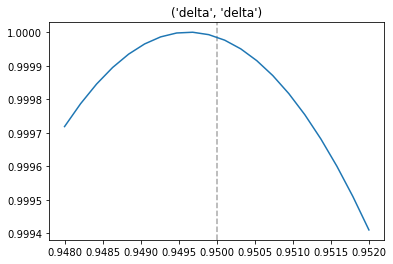

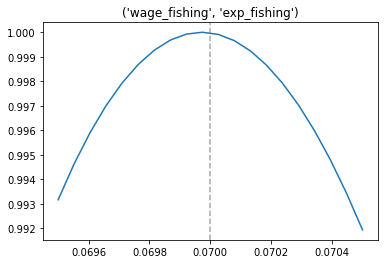

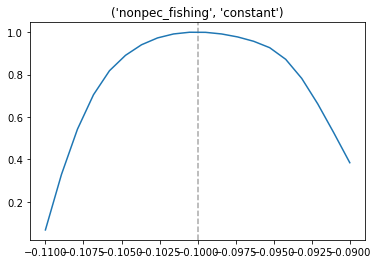

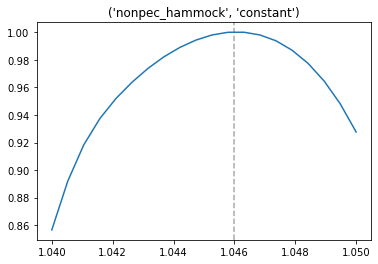

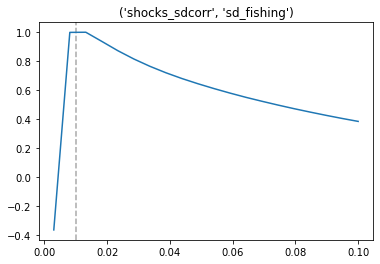

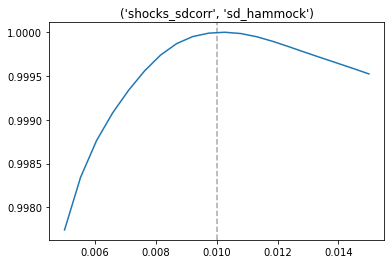

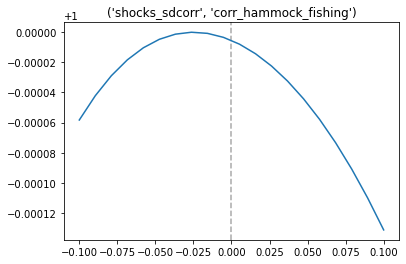

In [8]:
plot_likelihood(rslts, params_base)

### Maximum likelihood estimate

So far, we looked at the likelihood function in its entirety. Going forward, we will take a narrower view and just focus on the maximum likelihood estimate. We restrict our attention to the discount factor $\delta$ and treat it as the only unknown parameter. We will use [estimagic](https://estimagic.readthedocs.io/) for all our estimations. 

In [9]:
crit_func = rp.get_log_like_func(params_base, options_base, df)

However, we will make our life even easier and fix all parameters but the discount factor $\delta$.

In [10]:
constr_base = [
    {"loc": "shocks_sdcorr", "type": "fixed"},
    {"loc": "wage_fishing", "type": "fixed"},
    {"loc": "nonpec_fishing", "type": "fixed"},
    {"loc": "nonpec_hammock", "type": "fixed"},
]

We will start the estimation with a perturbation of the true value.

In [11]:
params_start = params_base.copy()
params_start.loc[("delta", "delta"), "value"] = 0.91

Now we are ready to deal with the selection and specification of the optimization algorithm.

In [15]:
algo_options = {"stopping_max_criterion_evaluations ": 100}
algo_name = "nag_pybobyqa"

results = maximize(
    criterion=crit_func,
    params=params_base,
    algorithm=algo_name,
    algo_options=algo_options,
    constraints=constr_base,
)

C:\Users\Annica\anaconda3\envs\ekw-lectures\lib\site-packages\estimagic\optimization\optimize.py:851: UserWarning: The following algo_options were ignored because they are not compatible with nag_pybobyqa:

 {'stopping_max_criterion_evaluations ': 100}
  warnings.warn(


Let's look at the results.

In [28]:
params_rslt = results["solution_params"]
params_rslt

lower  lower_bound   upper  upper_bound  \
category       name                                                             
delta          delta                 0.9480         -inf  0.9520          inf   
wage_fishing   exp_fishing           0.0695         -inf  0.0705          inf   
nonpec_fishing constant             -0.1100         -inf -0.0900          inf   
nonpec_hammock constant              1.0400         -inf  1.0500          inf   
shocks_sdcorr  sd_fishing            0.0030         -inf  0.1000          inf   
               sd_hammock            0.0050         -inf  0.0150          inf   
               corr_hammock_fishing -0.1000         -inf  0.1000          inf   

                                        value  
category       name                            
delta          delta                 0.949629  
wage_fishing   exp_fishing           0.070000  
nonpec_fishing constant             -0.100000  
nonpec_hammock constant              1.046000  
shocks_sdcorr  sd_fishing            0.010000  
               sd_hammock            0.010000  
               corr_hammock_fishing  0.000000

In [25]:
fval = results["solution_criterion"] * options_base["simulation_agents"]
print(f"criterion function at optimum {fval:5.3f}")

criterion function at optimum -10049.384


We need to set up a proper interface to use some other Python functionality going forward.

In [29]:
def wrapper_crit_func(crit_func, options_base, params_base, value):

    params = params_base.copy()
    params.loc["delta", "value"] = value

    return options_base["simulation_agents"] * crit_func(params)


p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, options_base, params_base)

We need to use the MLE repeatedly going forward.

In [30]:
delta_hat = params_rslt.loc[("delta", "delta"), "value"]

At the maximum, the second derivative of the log-likelihood is negative and we define the observed Fisher information  as follows

\begin{align*}
I(\hat{\theta}) \equiv -\frac{\partial^2 \log L(\hat{\theta})}{\partial^2 \theta}
\end{align*}

A larger curvature is associated with a strong peak, thus indicating less uncertainty about $\theta$.

In [31]:
delta_fisher = -nd.Derivative(p_wrapper_crit_func, n=2)([delta_hat])

In [32]:
delta_fisher

2101705.2240765863

### Score statistic and Score function

The Score function is the first-derivative of the log-likelihood.

\begin{align*}
S(\theta) \equiv \frac{\partial \log L(\theta)}{\partial \theta}
\end{align*}


#### Distribution

The asymptotic normality of the score statistic is of key importance in deriving the asymptotic normality of the maximum likelihood estimator. Here we simulate $1,000$ samples of $10,000$ individuals and compute the score function at the true values. I had to increase the number of simulated individuals as convergence to the asymptotic distribution just took way to long.

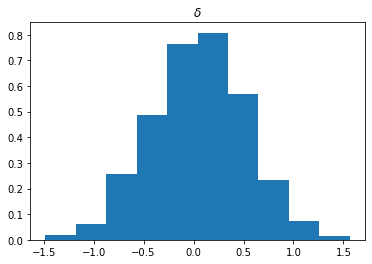

In [33]:
plot_score_distribution()

#### Linearity

We seek linearity of the score function around the true value so that the log-likelihood is reasonably well approximated by a second order Taylor-polynomial. 

\begin{align*}
\log L(\theta) \approx \log L(\hat{\theta}) + S(\hat{\theta})(\theta - \hat{\theta}) - \tfrac{1}{2} I(\hat{\theta}))(\theta - \hat{\theta})^2
\end{align*}

Since $S(\hat{\theta}) = 0$, we get:

\begin{align*}
\log\left(\frac{L(\theta)}{L(\hat{\theta})}\right) \approx - \tfrac{1}{2} I(\hat{\theta})(\theta - \hat{\theta})^2
\end{align*}

Taking the derivative to work with the score function, the following relationship is approximately true if the usual regularity conditions hold:

\begin{align*}
- I^{-1/2}(\hat{\theta}) S(\theta) \approx I^{1/2}(\hat{\theta}) (\theta - \hat{\theta})
\end{align*}



In [34]:
num_points, index = 10, ("delta", "delta")

upper, lower = params_base.loc[index, ["upper", "lower"]]
grid = np.linspace(lower, upper, num_points)

fds = np.tile(np.nan, num_points)
for i, point in enumerate(grid):
    fds[i] = nd.Derivative(p_wrapper_crit_func, n=1)([point])

norm_fds = fds * -(1 / np.sqrt(delta_fisher))
norm_grid = (grid - delta_hat) * (np.sqrt(delta_fisher))

In the best case we see a standard normal distribution of $I^{1/2} (\hat{\theta}) (\theta - \hat{\theta})$ and so it is common practice to evaluate the linearity over $-2$ and $2$.

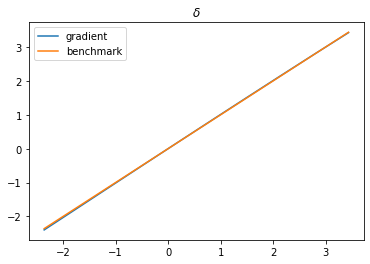

In [35]:
plot_score_function(norm_grid, norm_fds)

Alternative shapes are possible.

<img src="material/fig-quadratic-approximation.png" width="700" >

### Confidence intervals

How do we communicate the statistical evidence using the likelihood? Several notions exist that have different demands on the score function. Wile the Wald intervals rely on the asymptotic normality and linearity, likelihood-based intervals only require asymptotic normality. In well-behaved problems, both measures of uncertainty agree.




#### Wald intervals

In [36]:
rslt = list()
rslt.append(delta_hat - 1.96 * 1 / np.sqrt(delta_fisher))
rslt.append(delta_hat + 1.96 * 1 / np.sqrt(delta_fisher))
"{:5.3f} / {:5.3f}".format(*rslt)

'0.948 / 0.951'

#### Likelihood-based intervals

In [37]:
def root_wrapper(delta, options_base, alpha, index):

    crit_val = -0.5 * chi2.ppf(1 - alpha, 1)

    params_eval = params_base.copy()
    params_eval.loc[("delta", "delta"), "value"] = delta
    likl_ratio = options_base["simulation_agents"] * (
        crit_func(params_eval) - crit_func(params_base)
    )

    return likl_ratio - crit_val

In [38]:
brackets = [[0.75, 0.95], [0.95, 1.10]]

rslt = list()
for bracket in brackets:
    root = root_scalar(
        root_wrapper,
        method="bisect",
        bracket=bracket,
        args=(options_base, 0.05, index),
    ).root
    rslt.append(root)
print("{:5.3f} / {:5.3f}".format(*rslt))

0.948 / 0.951


## Bootstrap

We can now run a simple bootstrap to see how the asymptotic standard errors line up.

Here are some useful resources on the topic:

* Davison, A., & Hinkley, D. (1997). [Bootstrap methods and their application](https://www.amazon.de/dp/B00D2WQ02U/ref=sr_1_1?keywords=bootstrap+methods+and+their+application&qid=1574070350&s=digital-text&sr=1-1). Cambridge University Press, Cambridge.

* Hesterberg, T. C. (2015). [What teachers should know about the bootstrap: Resampling in the undergraduate statistics curriculum](https://amstat.tandfonline.com/doi/full/10.1080/00031305.2015.1089789#.XdZhBldKjIV), *The American Statistician, 69*(4), 371-386.

* Horowitz, J. L. (2001). [Chapter 52. The bootstrap](https://www.scholars.northwestern.edu/en/publications/chapter-52-the-bootstrap). In Heckman, J.J., & Leamer, E.E., editors, *Handbook of Econometrics, 5*, 3159-3228. Elsevier Science B.V.

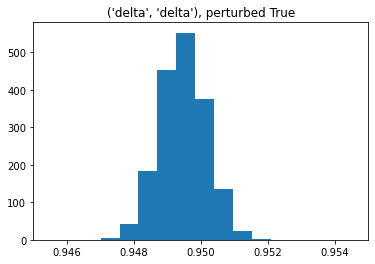

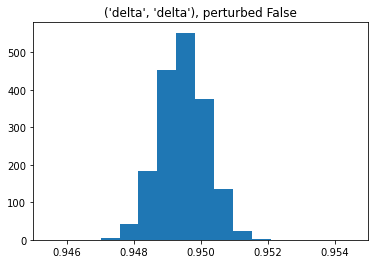

In [39]:
plot_bootstrap_distribution()

We can now construct the bootstrap confidence interval.

In [40]:
fname = "material/bootstrap.delta_perturb_true.pkl"
boot_params = pd.read_pickle(fname)

rslt = list()
for quantile in [0.025, 0.975]:
    rslt.append(boot_params.loc[("delta", "delta"), :].quantile(quantile))
print("{:5.3f} / {:5.3f}".format(*rslt))

0.948 / 0.951


### Numerical aspects

The shape and properties of the likelihood function are determined by different numerical tuning parameters such as quality of numerical integration, smoothing of choice probabilities. We would simply choose all components to be the "best",  but that comes at the cost of increasing the time to solution.

In [41]:
grid = np.linspace(100, 1000, 100, dtype=int)

rslts = list()
for num_draws in grid:
    options = options_base.copy()

    options["estimation_draws"] = num_draws
    options["solution_draws"] = num_draws

    start = timer()
    rp.get_solve_func(params_base, options)
    finish = timer()

    rslts.append(finish - start)

We are ready to see how time to solution increases as we improve the quality of the numerical integration by increasing the number of Monte Carlo draws.

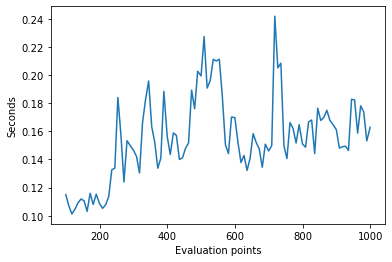

In [42]:
plot_computational_budget(grid, rslts)

We need to learn where to invest a limited computational budget. We focus on the following going forward:

* smoothing parameter for logit accept-reject simulator

* grid search across core parameters

#### Smoothing parameter

We now show the shape of the likelihood function for alternative choices of the smoothing parameter $\tau$. There exists no closed-form solution for the choice probabilities, so these are simulated. Application of a basic accept-reject (AR) simulator poses the two challenges. First, there is the ocurrance of zero probability simulation for low probability events which causes problems for the evaluation of the log-likelihood. Second, the choice probabilities are not smooth in the parameters and instead are a step function. This is why McFadden (1989) introduces a class of smoothed AR simulators. The logit-smoothed AR simulator is the most popular one and also implemented in `respy`. The implementation requires to specify the smoothing parameter $\tau$. As $\tau \rightarrow 0$ the logit smoother approaches the original indicator function.

* McFadden, D. (1989). [A method of simulated moments for estimation of discrete response models without numerical integration](https://www.jstor.org/stable/1913621?seq=1#metadata_info_tab_contents). *Econometrica, 57*(5), 995-1026.

* Train, K. (2009). [Discrete choice methods with simulation](https://eml.berkeley.edu/books/train1201.pdf). Cambridge University Press, Cambridge.


In [43]:
rslts = dict()

for tau in [0.01, 0.001, 0.0001]:

    index = ("delta", "delta")

    options = options_base.copy()
    options["estimation_tau"] = tau

    crit_func = rp.get_log_like_func(params_base, options, df)
    grid = np.linspace(0.948, 0.952, 20)

    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))

    rslts[tau] = fvals - np.max(fvals)

Now we are ready to inspect the shape of the likelihood function.

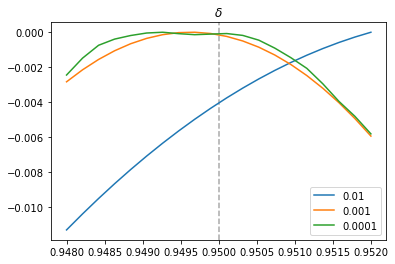

In [44]:
plot_smoothing_parameter(rslts, params_base, grid)

#### Grid search

We can look at the interplay of several major numerical tuning parameters. We combine choices for `simulation_agents`, `solution_draws`, `estimation_draws`, and `tau` to see how the maximum of the likelihood function changes. 

In [45]:
df = pd.read_pickle("material/tuning.delta.pkl")
df.loc[((10000), slice(None)), :]

delta
agents draws tau                   
10000  100   1.000000e-02     0.952
             1.000000e-03  0.949684
             1.000000e-04  0.949684
             1.000000e-05  0.949684
             1.000000e-06  0.949684
             1.000000e-07  0.949684
       1000  1.000000e-02     0.952
             1.000000e-03  0.950316
             1.000000e-04  0.950105
             1.000000e-05  0.950105
             1.000000e-06  0.950105
             1.000000e-07  0.950105
       10000 1.000000e-02     0.952
             1.000000e-03  0.950316
             1.000000e-04  0.950105
             1.000000e-05  0.950105
             1.000000e-06  0.950105
             1.000000e-07  0.950105